In [1]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [2]:
train = pd.read_csv("Data/processed_train2.csv")
test= pd.read_csv("Data/processed_test2.csv")
submission = pd.read_csv("Data/submission.csv")

In [3]:
train[:10]

,conversation,class
0,지금 당장 뉴스 기사 내가 불러준 대로 보도 해 사실 확인이 되지 않은 기사는 낼...,0.0
1,이 버러지 같은 게 너 내가 누군 줄 알아 손님 욕하시면 안 됩니다 어디서 말...,1.0
2,공책 돌려받길 원하면 빨리 뛰어봐 이 굼벵아 빨리 내놔 빨릐 내놓아야 빨리 ...,1.0
3,사장님 저기 말할게 있는데요 뭔데 임마 아니 우리 게임 회사는 전체이용가 게임이잖아...,3.0
4,죽고 싶어서 환장했어 왜 이렇게 말을 안 들어 죄송해요 한 번만 봐주세요 ...,0.0
5,야 이 시계 예쁜데 생일선물로 받은거야 이거 나 주고 가라 안돼 이게 어디 까불어 ...,2.0
6,새로 생긴 카페 가봤어 아니 아직 안 가봤어 거기 커피 진짜 맛있어 그래 ...,4.0
7,야 너 이리 와봐 이게 뭐야 네 뭐가 문제가 생겼나요 이새끼봐라 니가 뭘 했다고...,3.0
8,아니 지금 장난해 보고서가 이따위가 뭐야 지금 죄송합니다 죄송이고 나발이고 ...,3.0
9,형 그러지 마 왜 갑자기 나한테 그래 너야 말로 미쳤어 너 때문에 우리 다 망하...,0.0


In [4]:
print(train.shape) #train 약 45백개
print(test.shape) # test 약 5백개
print(submission.shape)

(4552, 2)
(500, 1)
(500, 2)


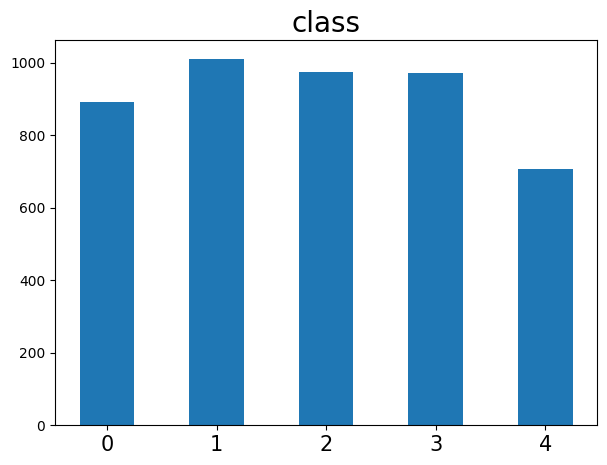

class
1.0    1011
2.0     973
3.0     970
0.0     892
4.0     706
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt 
# 데이터 분포 꽤나 balance !! 
feature = train['class']

plt.figure(figsize=(7,5)) 
plt.title('class', fontsize=20)
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize=15) 
plt.show()
print(temp) 

In [9]:
print('Max Conversation Length: ', np.max(train['conversation'].str.len()))  #전제 최대는 90자, 최소는 19자
print('Min Conversation Length: ', np.min(train['conversation'].str.len()))
print('Mean Conversation Lenght: ',np.mean(train['conversation'].str.len()))

Max Conversation Length:  885
Min Conversation Length:  41
Mean Conversation Lenght:  257.6258787346221


In [11]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SEED 고정, GPU설정

In [12]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


klue/roberta-large

In [15]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("klue/roberta-large")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ZAMTOL\.cache\huggingface\hub\models--klue--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are n

In [16]:
# SPLIT 
train, val = train_test_split(train, test_size=0.2, random_state=2021)

In [17]:
val.head()

,conversation,class
714,야 너 이 새끼 뭐 사러 가냐 네 왜요 너 오늘 돈 많아 보인다 좀 살면 돈 ...,2.0
388,도저히 상황이 안돼서 말씀하신 기간까지 마련하지 못한 점 죄송하게 생각합네다 그래...,0.0
3549,빨리빨리 일 처리 안 해 죄송합니다 김대리 이번에는 승진해야지 죄송합니다 빨리...,3.0
1874,요새 애들은 소갈머리가 없어 맞아요 부장님 죄송합니다 나때는 고개도 못들었어 난 눈...,3.0
1667,이번 주말에 여행 갈까 어디로 해변으로 가고 싶어 좋아 그럼 계획 세워보자 ...,4.0


In [18]:
test.head()

,text
0,아가씨 담배 한 갑 주소 네 4 500원입니다 어 네 지갑 어디 갔지 에이 버스...
1,우리 팀에서 다른 팀으로 갈 사람 없나 그럼 영지씨가 가는 건 어때 네 제가...
2,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요 제대로 좀 하지 네 똑바로 좀 하지 행...
3,이거 들어봐 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 요...
4,아무튼 앞으로 네가 내 와이파이야 응 와이파이 온 켰어 반말 주인님이라고도 ...


In [19]:
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
config = AutoConfig.from_pretrained('klue/roberta-large')
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained('klue/roberta-large', config=config)

c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
max_seq_len = 128  # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음

In [23]:
def convert_examples_to_features(sent_list, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids = [], [], []

    for sent in tqdm(sent_list, total=len(sent_list)):
        encoding_result = tokenizer.encode_plus(
            sent,
            max_length=max_seq_len,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )

        input_ids.append(encoding_result['input_ids'])
        attention_masks.append(encoding_result['attention_mask'])
        token_type_ids.append(encoding_result['token_type_ids'])

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    return (input_ids, attention_masks, token_type_ids)

In [24]:
X_train = convert_examples_to_features(train['conversation'],  max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/3641 [00:00<?, ?it/s]c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3641/3641 [00:00<00:00, 4287.83it/s]


In [25]:
# 최대 길이: 128
input_id = X_train[0][0]
attention_mask = X_train[1][0]
token_type_id = X_train[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

단어에 대한 정수 인코딩 : [    0   732  2116  4022   733   568  1376  2203  2275   732   780  6233
   752  2116  5390  2470   568  1170  2180  2778  1376  1170  6074  3866
  8835  3637  2728  2073  2227  2203  2275  1110  2069  2113  2116  2899
  2062  6148  2097  3690  2259  1378  5014  2318   743  1504  7171 24402
  1169   732  2116  3842  8705  3949 12421  2170  3839  2015  2529  3949
 23548   770  2052   717  2079  6045  2470  1389  2057  2138  3914  4577
  2529  6791  2154  7624  2097  2223  2181  4458  6892  2170  5331  4962
  2371  2088   752  4369  1875  2151  2042  2066  3679  2201  2203  2965
  3869  2097     2     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [26]:
X_valid = convert_examples_to_features(val['conversation'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 911/911 [00:00<00:00, 4054.16it/s]


In [28]:
X_test = convert_examples_to_features(test['text'],max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 500/500 [00:00<00:00, 3933.44it/s]


In [30]:
train_label = train['class'].tolist()
val_label = val['class'].tolist()

In [31]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
y_val = idx_encode.transform(val_label) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value: key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

{0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4}
{0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}


In [32]:
from transformers import TFBertForSequenceClassification

In [33]:
model_name = "'klue/roberta-large'"

In [34]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import TruncatedNormal
from transformers import TFAutoModel

class Klue_RobertaClassifier(Model):
    def __init__(self, model_name):
        super(Klue_RobertaClassifier, self).__init__()
        self.bert = TFAutoModel.from_pretrained("klue/roberta-large", num_labels=3, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.classifier = Dense(3, kernel_initializer=TruncatedNormal(0.02),activation='softmax') #가중치 초기화, 활성화함수

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        input_ids, attention_mask, token_type_ids=inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        prediction = self.classifier(pooled_output)

        return prediction

In [35]:
model = Klue_RobertaClassifier("klue/roberta-large")  #dropout=0.5까지

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

In [36]:
from transformers import AdamWeightDecay
optimizer = AdamWeightDecay(1e-5, weight_decay_rate=1e-4)  #과적합 방지
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)

model.fit(
    X_train, y_train, epochs=3, batch_size=8, validation_data=(X_valid, y_val),
    callbacks = [early_stopping])

Epoch 1/3


c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


ResourceExhaustedError: Graph execution error:

Detected at node 'klue__roberta_classifier/tf_roberta_model/roberta/encoder/layer_._5/output/dropout_17/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ZAMTOL\AppData\Local\Temp\ipykernel_3172\1473305745.py", line 8, in <module>
      model.fit(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ZAMTOL\AppData\Local\Temp\ipykernel_3172\2813980160.py", line 15, in call
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\modeling_tf_utils.py", line 1009, in run_call_with_unpacked_inputs
      symbolic_weight_name = "/".join(symbolic_weight.name.split("/")[1:])
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 1036, in call
      outputs = self.roberta(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\modeling_tf_utils.py", line 1009, in run_call_with_unpacked_inputs
      symbolic_weight_name = "/".join(symbolic_weight.name.split("/")[1:])
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 828, in call
      encoder_outputs = self.encoder(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 611, in call
      for i, layer_module in enumerate(self.layer):
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 617, in call
      layer_outputs = layer_module(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 556, in call
      layer_output = self.bert_output(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 464, in call
      hidden_states = self.dropout(inputs=hidden_states, training=training)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\layers\regularization\dropout.py", line 111, in call
      output = control_flow_util.smart_cond(training, dropped_inputs,
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\layers\regularization\dropout.py", line 108, in dropped_inputs
      return self._random_generator.dropout(
    File "c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\backend.py", line 1940, in dropout
      return tf.nn.dropout(inputs, rate=rate, noise_shape=noise_shape,
Node: 'klue__roberta_classifier/tf_roberta_model/roberta/encoder/layer_._5/output/dropout_17/dropout/random_uniform/RandomUniform'
OOM when allocating tensor with shape[8,128,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node klue__roberta_classifier/tf_roberta_model/roberta/encoder/layer_._5/output/dropout_17/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_46794]

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred.shape